In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from elephant.spike_train_generation import homogeneous_poisson_process
from scipy.ndimage import gaussian_filter1d
import elephant.conversion as conv
import neo as n
import quantities as pq
from quantities import Hz, s, ms
import random

In [2]:
def normalized_cross_corr(x,y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    x_cov_std = np.nanmax(np.sqrt(np.correlate(x - x_mean, x - x_mean, 'full')))
    y_cov_std = np.nanmax(np.sqrt(np.correlate(y - y_mean, y - y_mean, 'full')))

    normalization = x_cov_std * y_cov_std
        

    unnormalized_correlation = np.correlate(x - x_mean, y - y_mean, 'full')
    
    corr_array = unnormalized_correlation/normalization

    return(corr_array)

def max_norm_cross_corr(x1, x2):
    
    correlation= normalized_cross_corr(x1, x2)
    
    lag = abs(correlation).argmax() - len(x1)+1
    
    max_corr = max(abs(correlation))
    
    return(max_corr, lag)

def cross_correlation_matrix(data):
    
    #input: n x t matrix where n is the number of rois and t is the duration of the time series
    #return: n x n symmetric cross correlation matrix, nxn uppertriangular cross correlation matrix and lag matrix
    n, t = data.shape
    X = np.zeros((n,n))
    lag = np.zeros((n,n))
    
    for i in range(n-1):
        for j in range(i+1,n):
            X[i][j],lag[i][j] = max_norm_cross_corr(data[i,:],data[j,:])
    X[np.isnan(X)] = 0
    lag[np.isnan(lag)] = 0
    
    X_full = X + X.T
    lag = lag + lag.T
    
    return(X_full, X, lag)

def gaussian_filter(array,sigma):
    #sigma=0.25==gaussian kernel with length 3
    #sigma=0.5==gaussian kernel with length 5
    #sigma=1==gaussian kernel with length 9
    return(gaussian_filter1d(array,sigma))

def bin_time_series(array, binsize, gaussian = True, **kwargs):
    #input: nxt matrix 
    #returns: binned time series i.e. l x n x binsize
    
    n = array.shape[0] # number of neurons
    totalsize = array.shape[1] # total duration of spikes
    l = int(totalsize/binsize) # number of resulting layers
    if gaussian:
        for i in range(n):
            array[i] = gaussian_filter(array[i],kwargs['sigma'])
    
    A = np.zeros((l,n,binsize))
    for i in range(l):
        A[i] = array[:,i*binsize:(i+1)*binsize]
    return(A)

def jitter(spike):
    #jittering the given spike train
    jittered = np.zeros(spike.shape)
    for i in np.nonzero(spike)[1]:
        jitt = random.randint(-5,5)
        try:jittered[0,i+jitt] = 1
        except:jittered[0,i] = 1
    return(jittered)

## Produce spikes according to Poisson process

In [3]:
spike_rate = 10.0
time = 500.0# in miliseconds
neurons = 10
binsize = 50

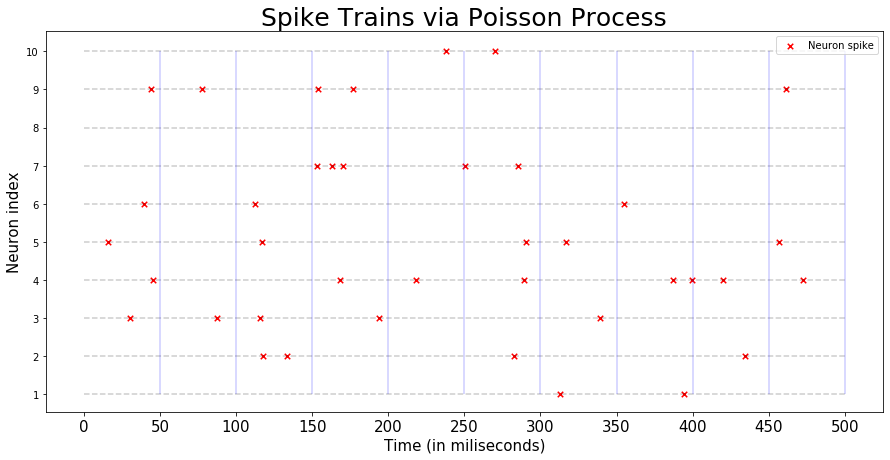

In [6]:
spiketrain_list = [homogeneous_poisson_process(rate = spike_rate*Hz, 
                                               t_start=0.0*ms, 
                                               t_stop = time*ms, 
                                               as_array=True) for i in range(neurons)]

fig,ax = plt.subplots(1,1,figsize=(15,7))
for i,e in enumerate(spiketrain_list):
    ax.hlines(i+1,0,time, alpha=0.2, linestyle = '--')
    for j,f in enumerate(e):
        if i+j == 0: ax.scatter(f,i+1, c = 'r', marker = 'x', s = 30, label = 'Neuron spike')
        else:  ax.scatter(f,i+1, c = 'r', marker = 'x', s = 30)
ax.set_title('Spike Trains via Poisson Process', fontsize =25)
ax.set_xlabel('Time (in miliseconds)', fontsize = 15)
ax.set_ylabel('Neuron index', fontsize = 15)
ax.set_xticks([i*binsize for i in range(int(time/binsize))]+[time])
ax.tick_params(axis='x', labelsize = 15)
ax.set_yticks([i for i in range(1,neurons+1)])
ax.vlines([(i+1)*binsize for i in range(int(time/binsize))], 1, neurons, alpha =0.2, color = 'b')
spiketrain_list[0]
plt.legend()
#plt.savefig('/Users/bengieru/Desktop/mln_v0/fake_spike_binned.pdf')

In [8]:
spikes = np.zeros((neurons,int(time)))
for i,e in enumerate(spiketrain_list):
    for j,f in enumerate(e):
        spikes[i][int(f)] = 1

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


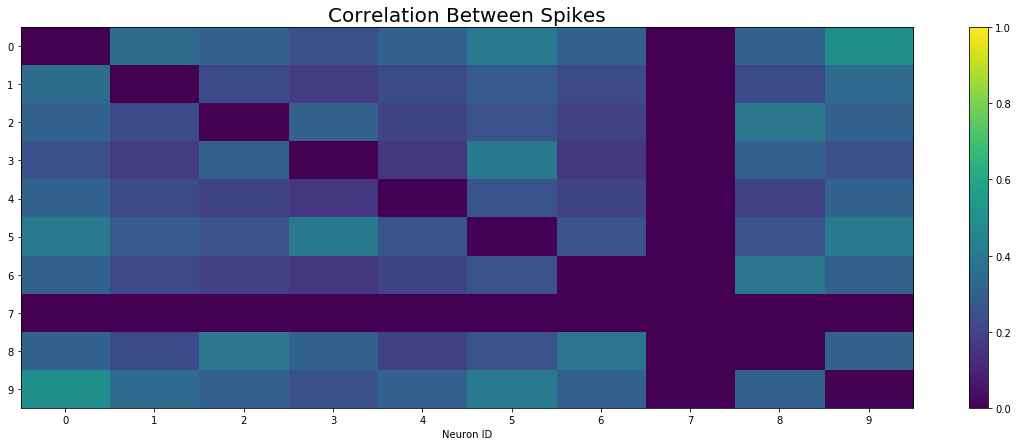

In [9]:
adjacency_matrices = cross_correlation_matrix(spikes)[0]
fig,ax = plt.subplots(1, 1, figsize = (20,7))
im = ax.imshow(adjacency_matrices, interpolation='nearest', aspect='auto', vmin = 0, vmax=1)
ax.set_title('Correlation Between Spikes', fontsize = 20)
ax.set_xticks([i for i in range(neurons)])
ax.set_yticks([i for i in range(neurons)])
ax.set_xlabel('Neuron ID')
fig.colorbar(im)
#plt.savefig('/Users/bengieru/Desktop/mln_v0/fake_corre_nonbinned.pdf')

### if we want to sparse

In [ ]:
#spikes = lil_matrix((len(spiketrain_list),int(time)))
#for i,e in enumerate(spiketrain_list):
    #for j,f in enumerate(e):
        #spikes._set_intXint(i,int(f),1)

## Put it into a nxt matrix

In [ ]:
spikes = np.zeros((neurons,int(time)))
for i,e in enumerate(spiketrain_list):
    for j,f in enumerate(e):
        spikes[i][int(f)] = 1

Text(0.5, 0, 'Time (in miliseconds)')

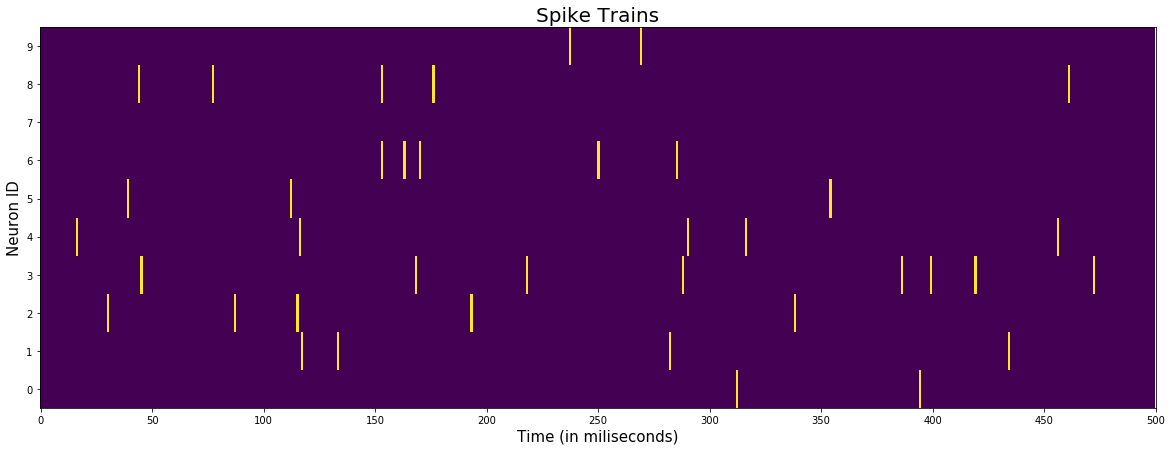

In [10]:
fig,ax = plt.subplots(1, 1, figsize = (20,7))
ax.imshow(spikes, origin = 'bottom left', interpolation='nearest', aspect='auto')
ax.set_xticks([i*binsize for i in range(int(time/binsize))]+[time])
ax.set_yticks([i for i in range(neurons)])
ax.set_title('Spike Trains', fontsize =20)
ax.set_ylabel('Neuron ID', fontsize =15)
ax.set_xlabel('Time (in miliseconds)', fontsize =15)
#plt.savefig('/Users/bengieru/Desktop/mln_v0/fake_spiketrain.pdf')

## Bin the created spike trains and apply a gaussian kernel

In [11]:
standard_dev = 1.2
layers = int(time/binsize)
binned_spikes = bin_time_series(spikes, binsize, gaussian = True, sigma = standard_dev) # bin the spikes into fixed length and apply gaussian kernel of length 3

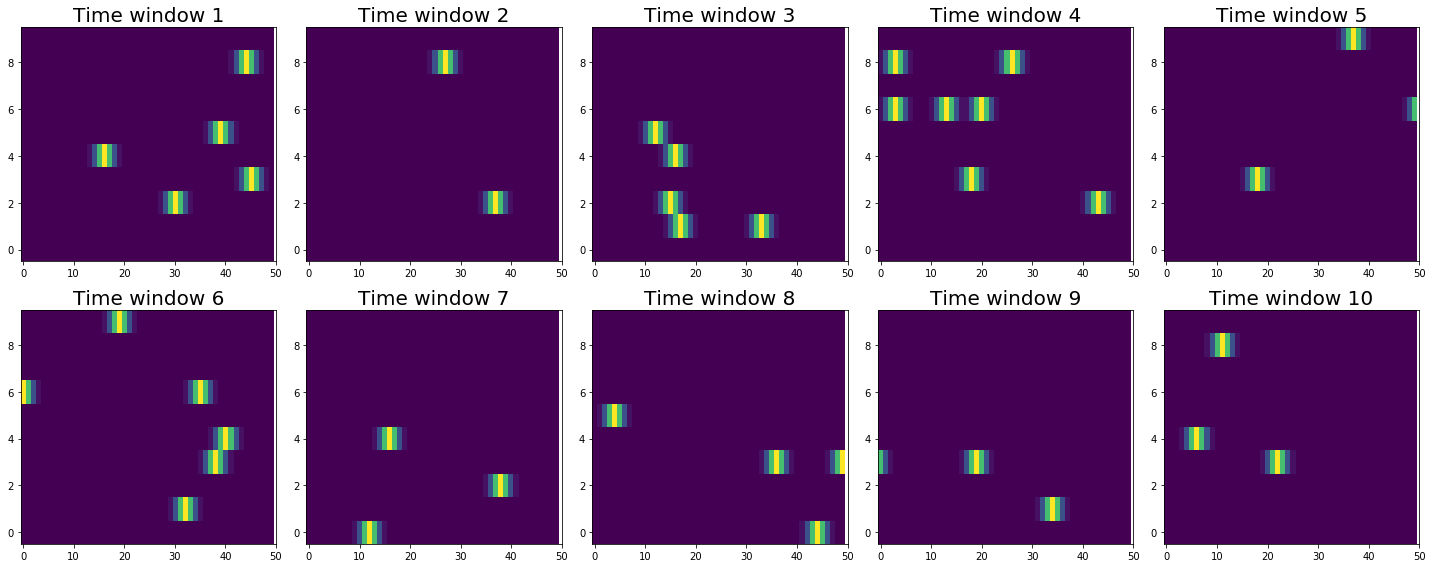

In [12]:
fig,ax = plt.subplots(2,5,figsize=(20,8))
for i in range(2):
    for j in range(5):
        ax[i][j].imshow(binned_spikes[i*5+j], origin = 'bottom left', interpolation='nearest', aspect='auto')
        ax[i][j].set_title('Time window %d'%(i*5+j+1), fontsize = 20)
        ax[i][j].set_xticks([i*10 for i in range(6)])
plt.tight_layout()
#plt.savefig('/Users/bengieru/Desktop/mln_v0/fake_corre_binned_gauss.pdf')

In [13]:
adjacency_matrices = []
for i in range(layers):
    adjacency_matrices.append(cross_correlation_matrix(binned_spikes[i])[0])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


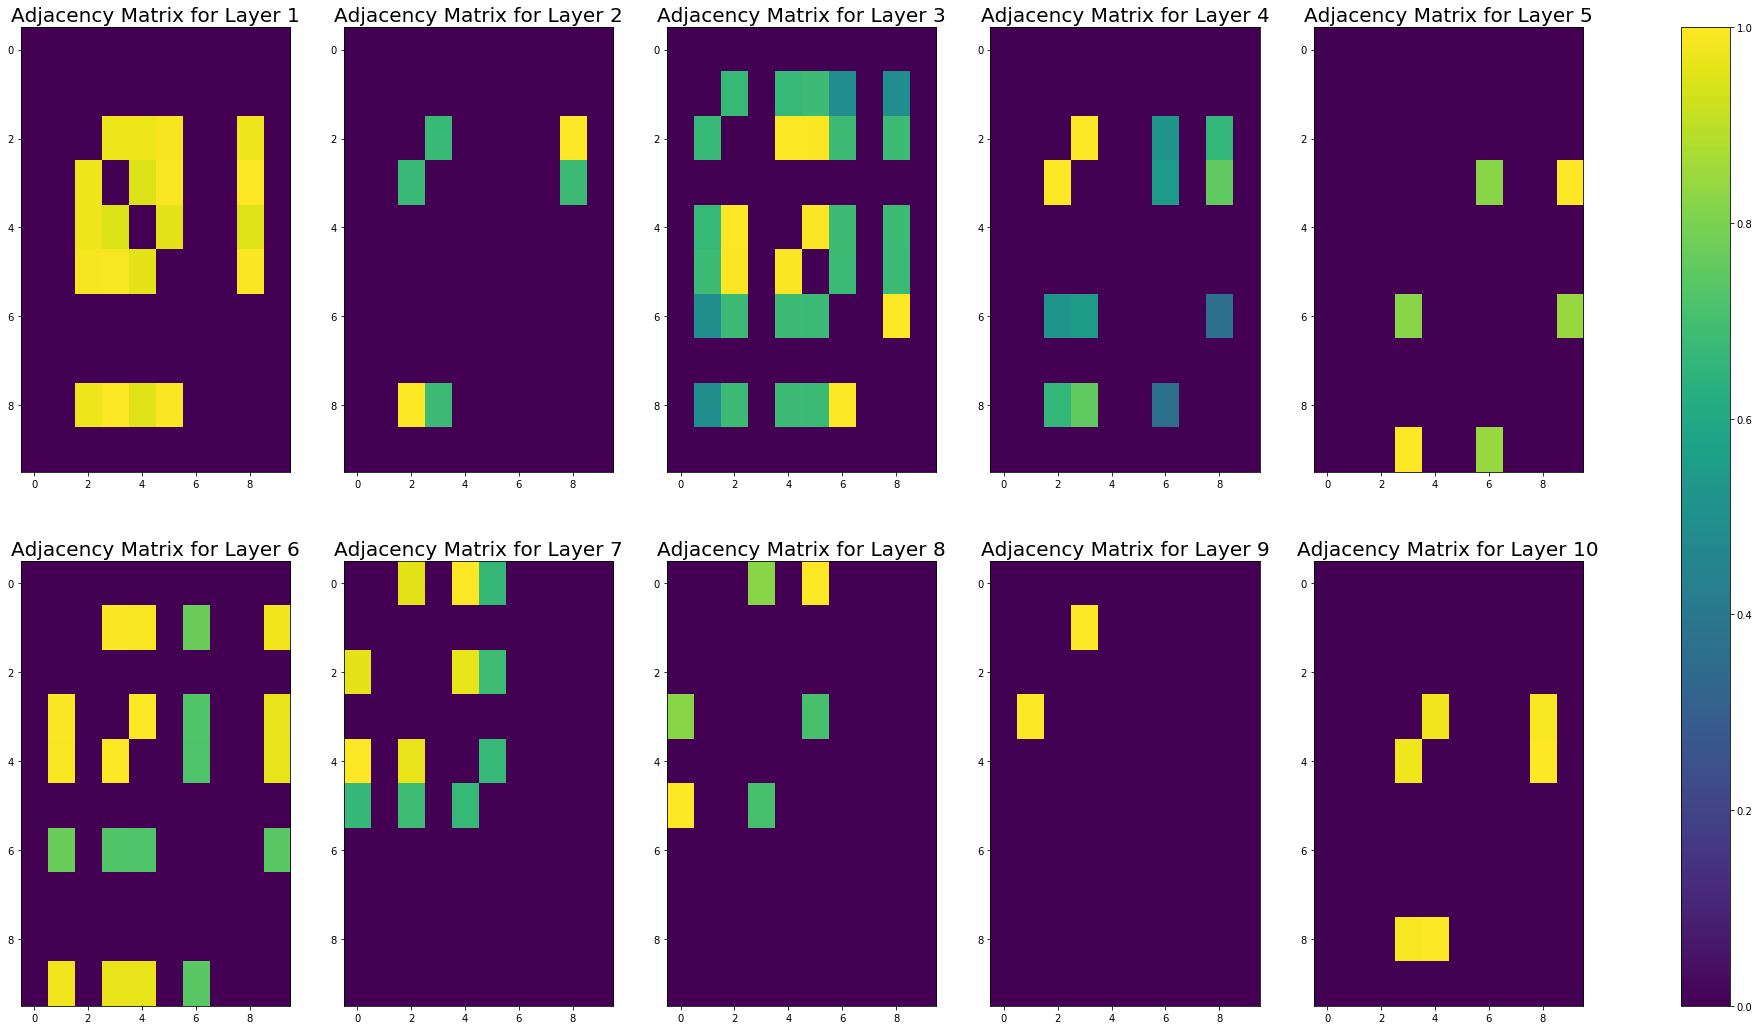

In [14]:
fig,ax = plt.subplots(2,5,figsize=(35,18))
for i in range(2):
    for j in range(5):
        ax[i][j].imshow(adjacency_matrices[i*5+j], interpolation='nearest', aspect='auto')
        ax[i][j].set_title('Adjacency Matrix for Layer %d'%(i*5+j +1),fontsize=20)
        
fig.colorbar(im, ax=ax.ravel().tolist())
#plt.savefig('/Users/bengieru/Desktop/mln_v0/adjacency.pdf')

## Create 5 communities that are merging over time

In [15]:
spike_rate = 10.0
time = 1000.0# in miliseconds
neurons = 1

In [16]:
seconds = 5
master_train = []
for i in range(seconds):
    if i == 0: spike_rate = 10
    else:spike_rate = 30
    spiketrain = [homogeneous_poisson_process(rate = spike_rate*Hz, t_start = 0.0*ms, t_stop = time*ms, as_array=True) for i in range(neurons)]
    master_train.append(spiketrain[0])
master_spiketrain = master_train[0]
for i in range(1,seconds):
    master_spiketrain = np.append(master_spiketrain,master_train[i]+1000*i)
masterspikes = np.zeros((1,int(time)*seconds))
for i,e in enumerate(master_spiketrain):
    masterspikes[0][int(e)] = 1

In [17]:
commsize = 20
comm = np.zeros((commsize, seconds*int(time)))
comm[0] = masterspikes
for i in range(1,commsize):
    comm[i] = jitter(masterspikes)

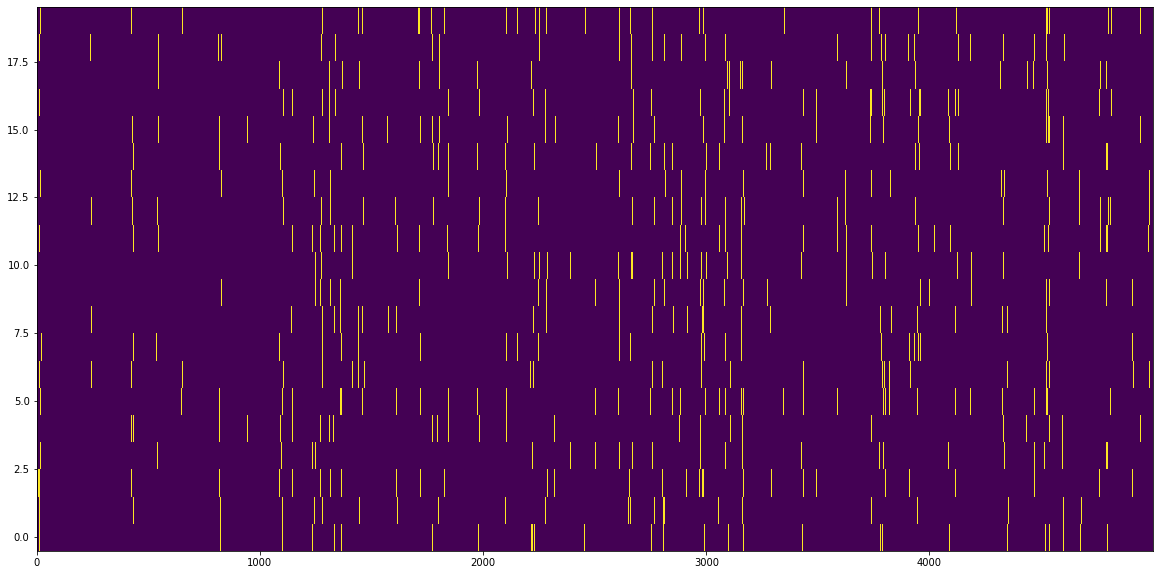

In [18]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
ax.imshow(comm, origin = 'bottom left', interpolation='nearest', aspect='auto')

In [19]:
spiketrain1 = [homogeneous_poisson_process(rate = spike_rate*Hz, t_start = 0.0*ms, t_stop = time*ms, as_array=True) for i in range(neurons)]
spikes1 = np.zeros((1,seconds*int(time)))
for i,e in enumerate(spiketrain1):
    for j,f in enumerate(e):
        spikes1[i][int(f)] = 1
for i in range(1000,5000):
    spikes1[0][i] = masterspikes[0][i]

In [20]:
commsize = 20
comm1 = np.zeros((commsize, seconds*int(time)))
comm1[0] = spikes1
for i in range(1,commsize):
    comm1[i] = jitter(spikes1)

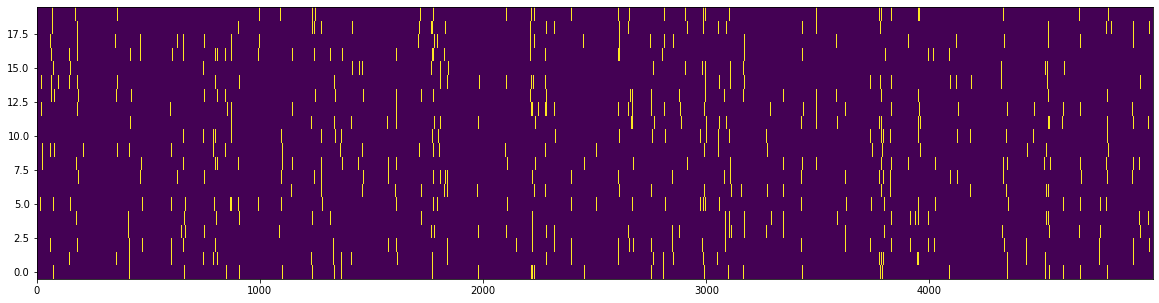

In [21]:
fig,ax = plt.subplots(1,1,figsize=(20,5))
ax.imshow(comm1, origin = 'bottom left', interpolation='nearest', aspect='auto')

In [22]:
spiketrain2 = [homogeneous_poisson_process(rate = spike_rate*Hz, t_start = 0.0*ms, t_stop = 2*time*ms, as_array=True) for i in range(neurons)]
spikes2 = np.zeros((1,seconds*int(time)))
for i,e in enumerate(spiketrain2):
    for j,f in enumerate(e):
        spikes2[i][int(f)] = 1
for i in range(2000,5000):
    spikes2[0][i] = masterspikes[0][i]

In [23]:
commsize = 20
comm2 = np.zeros((commsize, seconds*int(time)))
comm2[0] = spikes2
for i in range(1,commsize):
    comm2[i] = jitter(spikes2)

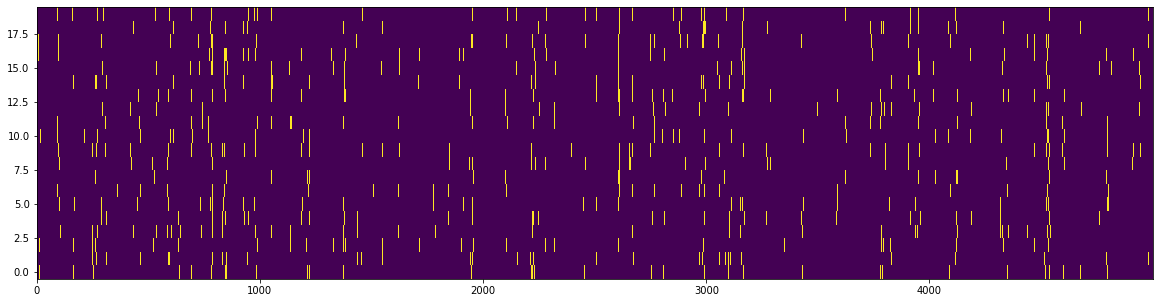

In [24]:
fig,ax = plt.subplots(1,1,figsize=(20,5))
ax.imshow(comm2, origin = 'bottom left', interpolation='nearest', aspect='auto')

In [25]:
spiketrain3 = [homogeneous_poisson_process(rate = spike_rate*Hz, t_start = 0.0*ms, t_stop = 3*time*ms, as_array=True) for i in range(neurons)]
spikes3 = np.zeros((1,seconds*int(time)))
for i,e in enumerate(spiketrain3):
    for j,f in enumerate(e):
        spikes3[i][int(f)] = 1
for i in range(3000,5000):
    spikes3[0][i] = masterspikes[0][i]

In [26]:
commsize = 20
comm3 = np.zeros((commsize, seconds*int(time)))
comm3[0] = spikes3
for i in range(1,commsize):
    comm3[i] = jitter(spikes3)

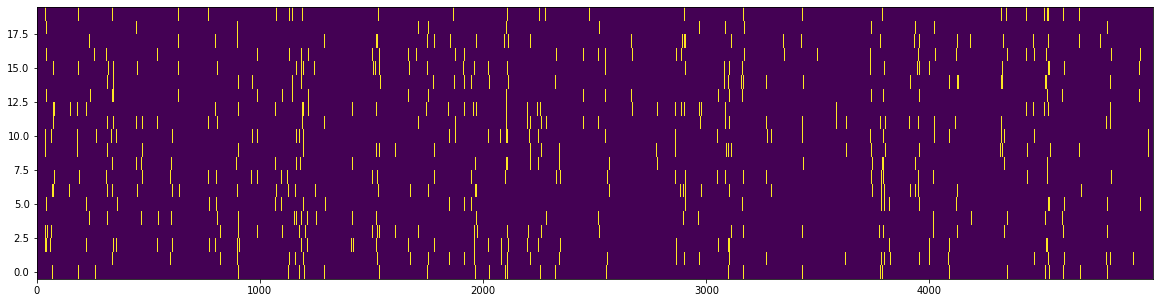

In [27]:
fig,ax = plt.subplots(1,1,figsize=(20,5))
ax.imshow(comm3, origin = 'bottom left', interpolation='nearest', aspect='auto')

In [28]:
spiketrain4 = [homogeneous_poisson_process(rate = spike_rate*Hz, t_start = 0.0*ms, t_stop = 4*time*ms, as_array=True) for i in range(neurons)]
spikes4 = np.zeros((1,seconds*int(time)))
for i,e in enumerate(spiketrain4):
    for j,f in enumerate(e):
        spikes4[i][int(f)] = 1
for i in range(4000,5000):
    spikes4[0][i] = masterspikes[0][i]

In [29]:
commsize = 20
comm4 = np.zeros((commsize, seconds*int(time)))
comm4[0] = spikes4
for i in range(1,commsize):
    comm4[i] = jitter(spikes4)

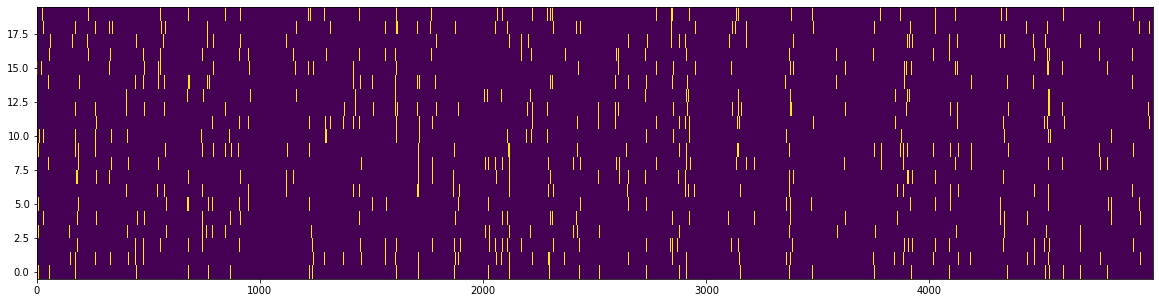

In [30]:
fig,ax = plt.subplots(1,1,figsize=(20,5))
ax.imshow(comm4, origin = 'bottom left', interpolation='nearest', aspect='auto')

In [31]:
##append everyting
k = np.append(comm,comm1,axis=0)
k1 = np.append(k,comm2,axis=0)
k2 = np.append(k1,comm3,axis=0)
spikes = np.append(k2,comm4,axis=0)

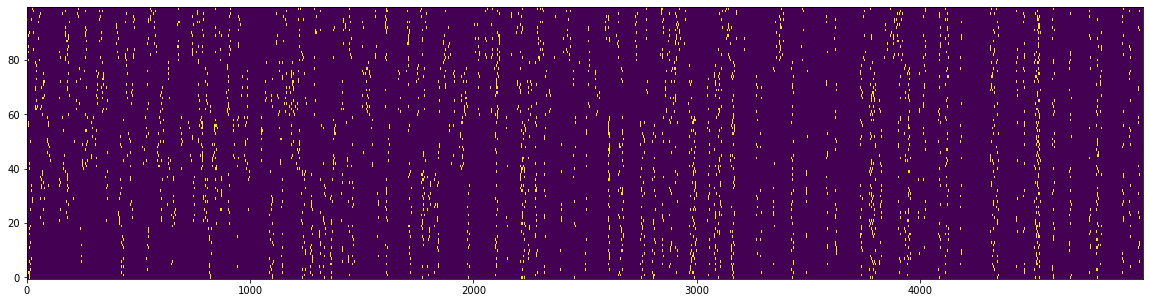

In [32]:
fig,ax = plt.subplots(1,1,figsize=(20,5))
ax.imshow(spikes, origin = 'bottom left', interpolation='nearest', aspect='auto')

In [33]:
binsize = 1000
standard_dev = 1.2
layers = int(time*seconds/binsize)
binned_spikes = bin_time_series(spikes, binsize, gaussian = True, sigma = standard_dev) # bin the spikes into fixed length and apply gaussian kernel of length 3

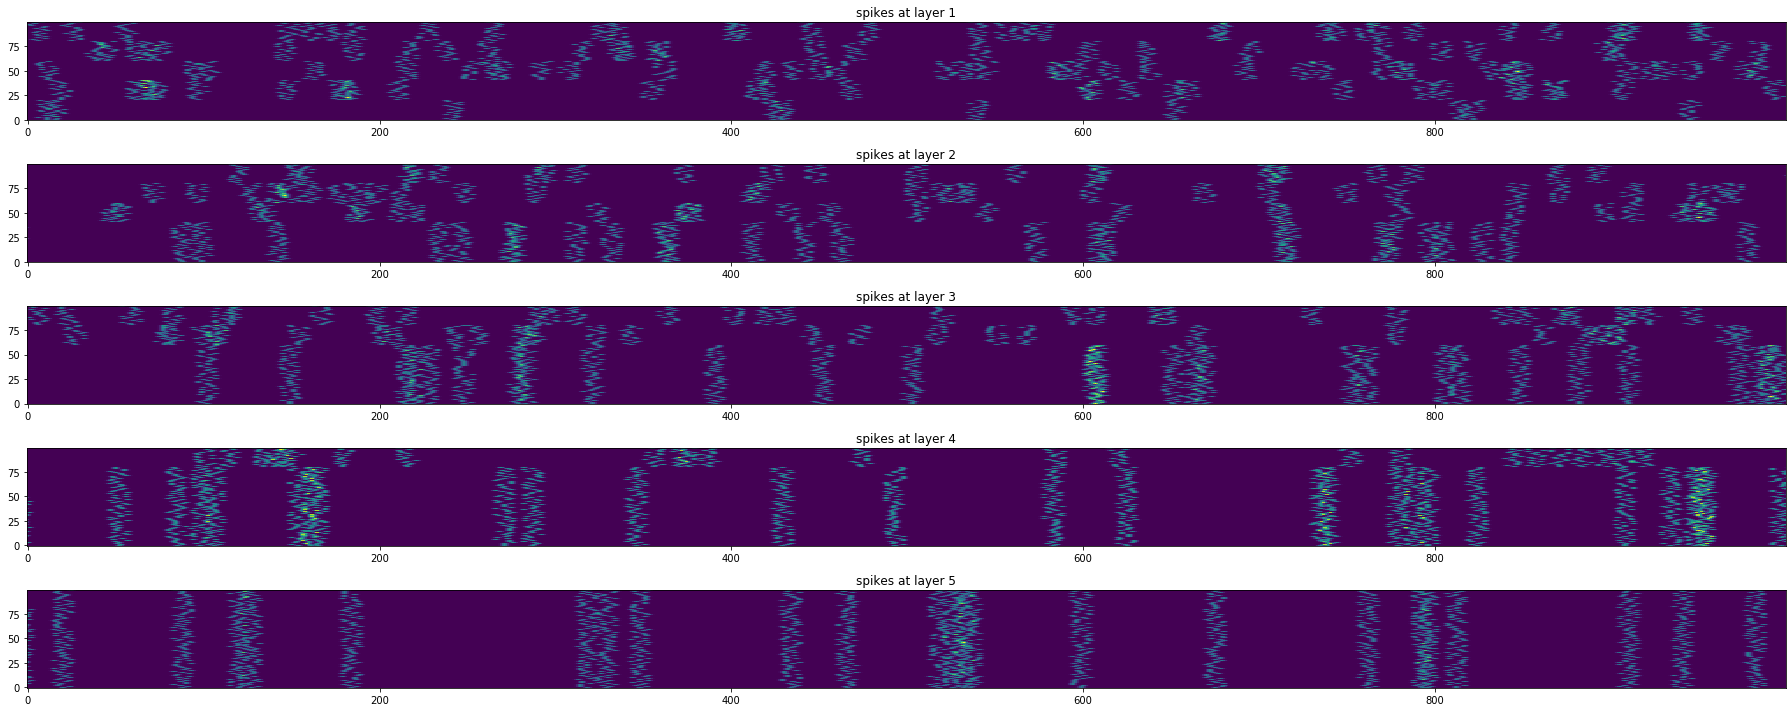

In [34]:
fig,ax = plt.subplots(layers,1,figsize=(25,10))
for i in range(layers):
    ax[i].imshow(binned_spikes[i], origin = 'bottom left', interpolation='nearest', aspect='auto')
    ax[i].set_title('spikes at layer %d'%(i+1))
plt.tight_layout()

In [35]:
adjacency_matrices = []
for i in range(layers):
    adjacency_matrices.append(cross_correlation_matrix(binned_spikes[i])[0])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


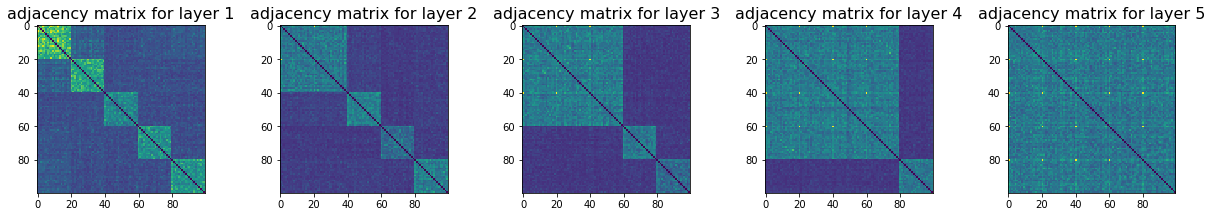

In [36]:
fig,ax = plt.subplots(1,layers,figsize=(17,10))
for i in range(layers):
    k = ax[i].imshow(adjacency_matrices[i])
    ax[i].set_title('adjacency matrix for layer %d'%(i +1), fontsize = 16)
plt.tight_layout()
#plt.colorbar(k)